In [1]:
### Import libraries ###
import numpy as np
import pandas as pd
import time, os, sys
import collections
from scipy.optimize import minimize 

from sklearn.metrics import log_loss, brier_score_loss
from sklearn.model_selection import train_test_split 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers
from keras.losses import categorical_crossentropy
initializer = tf.keras.initializers.GlorotNormal()

In [2]:
### Data preprocessing ###

### Load CIFAR-10 dataset ###
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

### Normalize the images to pixel values (0, 1) ###
train_im, test_im = train_im/255.0 , test_im/255.0

#### Check the format of the data ###
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### Check the shape of the data ###
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

### One hot encoding for labels ###

train_lab_categorical = tf.keras.utils.to_categorical(train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(test_lab, num_classes=10, dtype='uint8')

### Spliting data into train and test subsets ###
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

### Data Augumentation ###
batch_size = 64 

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
### Generate validation dataset ###
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)
train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [4]:
###############################################################################################################################

In [5]:
def identity_block(X, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2 = filters
    
    X_skip = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_regularizer=l2(0.001))(X)
    X = BatchNormalization(name = bn_name_base + '1a')(X)
    X = Activation(activations.relu)(X)
        
    X = Conv2D(filters = F1, kernel_size = (3,3), strides = (1,1), padding = 'same', name = conv_name_base + '2b',kernel_regularizer=l2(0.001))(X)
    X = BatchNormalization(name = bn_name_base + '1b')(X)
    X = Activation(activations.relu)(X)

    X = Conv2D(filters = F2, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_regularizer=l2(0.001))(X_skip)
    X = BatchNormalization(name = bn_name_base + '1c')(X)

    X = Add()([X, X_skip])
    X = Activation('relu')(X)
        
    return X

In [6]:
def convolutional_block(X,  filters, stage, block, s = 2):
        
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2 = filters
    X_skip = X
    
    X = Conv2D(F1, (1, 1), strides = (s,s), padding='valid', name = conv_name_base + '2a', kernel_regularizer=l2(0.001))(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F1, kernel_size = (3,3), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer=l2(0.001))(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_regularizer=l2(0.001))(X)
    X = BatchNormalization(name = bn_name_base + '2c')(X)
    
    X_skip = Conv2D(filters = F2, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_regularizer=l2(0.001))(X_skip)
    X_skip = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_skip)
    
    X = Add()([X, X_skip])
    X = Activation('relu')(X)
   
    return X

In [9]:
def resnet50():
    input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3]))
    classes = 10
    
    ### ZERO PADDING
    X = ZeroPadding2D(padding=(3, 3))(input_im)
    
    ### STAGE 1 == stem
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation(activations.relu)(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    ### STAGE 2
    X = convolutional_block(X, filters = (64, 256), stage = 2, block='a', s = 1)
    X = identity_block(X, (64, 256), stage=2, block='b')

    
    ### STAGE 3 
    X = convolutional_block(X,  filters = (128, 512), stage = 3, block='a', s = 2)
    X = identity_block(X, filters = (128, 512), stage=3, block='b')
    X = identity_block(X, filters = (128, 512), stage=3, block='c')

    
    ### STAGE 4
    X = convolutional_block(X,  filters = (256, 1024), stage = 4, block='a', s = 2)
    X = identity_block(X, filters = (256, 1024), stage=4, block='b')
    X = identity_block(X, filters = (256, 1024), stage=4, block='c')
    X = identity_block(X,filters = (256,  1024), stage=4, block='d')


    ### AVG POOL
    X = AveragePooling2D((2, 2),padding='same')(X)
    
    ### FLATTING
    X = Flatten()(X)
    
    ### FC
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = 'he_normal')(X)
    model = Model(inputs = input_im, outputs = X, name='resnet50')
    return model

In [10]:
resnet50_model = resnet50()

In [11]:
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

 res3b_branch2c (Conv2D)        (None, 4, 4, 512)    262656      ['activation_9[0][0]']           
                                                                                                  
 bn3b_branch1c (BatchNormalizat  (None, 4, 4, 512)   2048        ['res3b_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_3 (Add)                    (None, 4, 4, 512)    0           ['bn3b_branch1c[0][0]',          
                                                                  'activation_9[0][0]']           
                                                                                                  
 activation_12 (Activation)     (None, 4, 4, 512)    0           ['add_3[0][0]']                  
                                                                                                  
 res3c_bra

                                                                                                  
 fc10 (Dense)                   (None, 10)           10250       ['flatten[0][0]']                
                                                                                                  
Total params: 5,757,578
Trainable params: 5,739,786
Non-trainable params: 17,792
__________________________________________________________________________________________________


In [11]:
### Training NN model ###
resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=100, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv)

### Saving model ###
resnet50_model.save('ResNet_64_100.h5')

Epoch 1/100
625/625 [==============================] - 405s 642ms/step - loss: 6.0470 - accuracy: 0.4048 - val_loss: 4.0138 - val_accuracy: 0.3392
Epoch 2/100
625/625 [==============================] - 393s 629ms/step - loss: 2.5569 - accuracy: 0.5144 - val_loss: 2.4351 - val_accuracy: 0.4625
Epoch 3/100
625/625 [==============================] - 395s 631ms/step - loss: 1.8630 - accuracy: 0.5597 - val_loss: 1.6042 - val_accuracy: 0.6201
Epoch 4/100
625/625 [==============================] - 395s 633ms/step - loss: 1.6644 - accuracy: 0.5853 - val_loss: 1.5859 - val_accuracy: 0.5854
Epoch 5/100
625/625 [==============================] - 395s 631ms/step - loss: 1.5780 - accuracy: 0.6031 - val_loss: 1.5428 - val_accuracy: 0.6129
Epoch 6/100
625/625 [==============================] - 395s 632ms/step - loss: 1.5139 - accuracy: 0.6140 - val_loss: 1.6816 - val_accuracy: 0.5491
Epoch 7/100
625/625 [==============================] - 397s 636ms/step - loss: 1.4831 - accuracy: 0.6257 - val_loss: 1

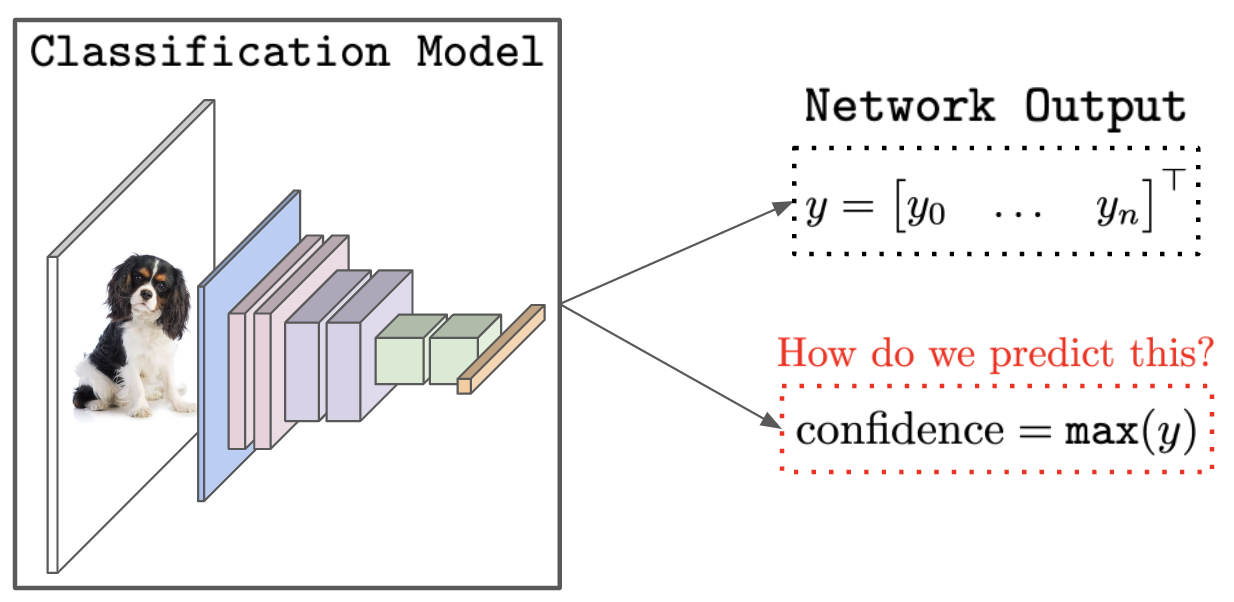

In [12]:
def predict( input_array: np.ndarray) -> np.ndarray:

    model = tf.keras.models.load_model('ResNet_64_100.h5')
    predictions = model.predict(input_array, verbose = 0)
    
    return predictions

def confidence_calculation( input_array: np.ndarray) -> np.ndarray:
    
    confidence = np.max(input_array, axis=1) 
    return confidence


def class_prediction( input_array: np.ndarray) -> np.ndarray:
    
    predicted_class = np.argmax(input_array, axis=1) 
    return predicted_class

predictions = predict(test_im)
predicted_class = class_prediction(predictions)
confidence = confidence_calculation(predictions)

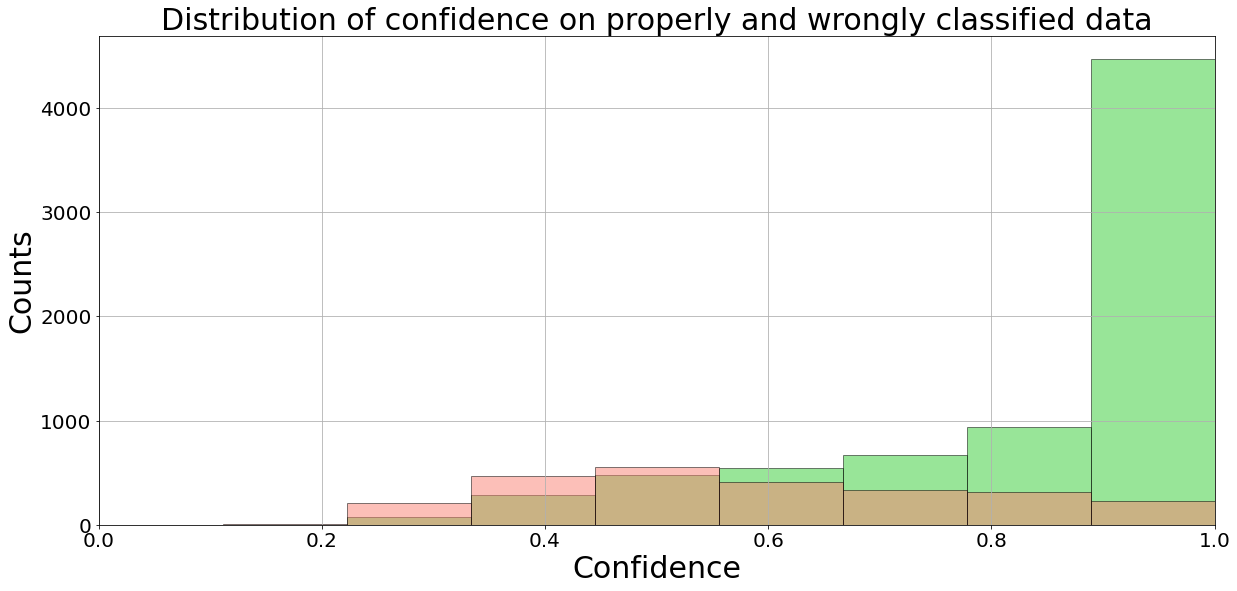

In [14]:
### Histogram with distribution of confidence on properly and wropngly classified data ###

df1 = pd.DataFrame(data = predictions,  columns = class_types)
df2 = pd.DataFrame(np.transpose(predicted_class), columns = ['prediction'])
df3 = pd.DataFrame(np.transpose(confidence), columns = ['confidence'])
df4 = pd.DataFrame(np.transpose(list(test_lab.flatten())), columns = ['label'])
df_concat = pd.concat([df1,df2,df3, df4], axis=1)
df_properly_classified = df_concat[df_concat['prediction'] == df_concat['label']]
df_wrongly_classified = df_concat[df_concat['prediction'] != df_concat['label']]

fig, ax = plt.subplots()
fig.set_size_inches(20, 9, forward=True)
bins = np.linspace(0, 1, 10)
ax.hist(df_properly_classified[['confidence']], bins, alpha=0.5, color='limegreen', histtype='bar', ec='black')
ax.hist(df_wrongly_classified[['confidence']], bins, alpha=0.5,color = 'salmon', histtype='bar', ec='black')


ax.margins(0.05)

plt.title('Distribution of confidence on properly and wrongly classified data',fontsize=30)
plt.xlabel('Confidence',fontsize=30)
plt.ylabel('Counts',fontsize=30)
plt.xticks(fontsize = 20) 
plt.yticks(fontsize = 20) 
plt.xlim(0, 1)
plt.grid()
plt.show()


In [ ]:
### References ### 
'''
Article: ResNet50
CNN: stanford 
Code: https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/


Article: https://arxiv.org/pdf/1706.04599.pdf
Code: https://github.com/markus93/NN_calibration
'''

In [ ]:
#### NOTES


def hist_bars(row):
    if 0>= row['max_value'] <0.1:
        val = 0
    elif 0.1>= row['max_value'] <0.2:
        val = 10
    elif 0.2>= row['max_value'] <0.3:
        val = 20
    elif 0.3>= row['max_value'] <0.4:
        val = 30
    elif 0.4>= row['max_value'] <0.5:
        val = 40
    elif 0.5>= row['max_value'] <0.6:
        val = 50
    elif 0.6>= row['max_value'] <0.7:
        val = 60
    elif 0.7>= row['max_value'] <0.8:
        val = 70
    elif 0.8>= row['max_value'] <0.9:
        val = 80
    elif 0.9>= row['max_value'] <=1:
        val = 90
    return val

def missclassified(row):
    if row['prediction'] == row['label']:
        val = 0
    else:
        val = 1
    return val


df_concat['max_value'] = df_concat[['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']].apply(np.max, axis=1)
df_concat['missclassified?'] = df_concat['set_of_numbers'].apply(lambda x: 'True' if x <= 4 else 'False')
df_concat['missclassified'] = df_concat.apply(missclassified, axis=1)
df_properly_classified = df_concat.loc[df_concat['missclassified'] == 0]
df_wrongly_classified = df_concat.loc[df_concat['missclassified'] == 1]